In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('stationary_raw_data.csv')# read in data compiled in Slope Models

In [3]:
pd.options.display.max_columns = None
df.head()

,ZipCode,County,State,ZORI,Year,Month,ZHVI,HPI,AQI,Population,Unemployment,Percent Bachelors,Permits,Total_Households,Med_Income,PCE,Rental Vacancy Rate,Job Openings,CommuteTime,Salwrkr,Govwrkr,GRAPI,Gini_Index,P_Density
0,10025,New York,NY,3020.0,2014,2,1056185.0,NaN,62.107143,1636268.0,7.1,31.2,1458.0,762228.0,76089.0,1.455676,4.5,212.0,31.3,84.1,8.3,734.7,0.5939,48582.779097
1,60657,Cook,IL,1583.0,2014,2,441010.0,158.76,59.571429,5246456.0,9.1,21.8,269.0,1938055.0,55069.0,1.455676,6.7,154.0,32.8,84.1,11.3,1440.3,0.4982,3209.057490
2,10023,New York,NY,3145.0,2014,2,1015651.0,NaN,62.107143,1636268.0,7.1,31.2,1458.0,762228.0,76089.0,1.455676,4.5,212.0,31.3,84.1,8.3,734.7,0.5939,48582.779097
3,77494,Fort Bend,TX,1746.0,2014,2,311407.0,154.29,NaN,685345.0,4.9,28.3,4368.0,214215.0,87973.0,1.455676,6.5,374.0,32.3,81.8,12.4,48.8,0.4318,773.431064
4,60614,Cook,IL,1752.0,2014,2,564138.0,146.37,59.571429,5246456.0,9.1,21.8,269.0,1938055.0,55069.0,1.455676,6.7,154.0,32.8,84.1,11.3,1440.3,0.4982,3209.057490


# County level data collection

In [4]:
count_area = pd.read_csv('land_area.csv')

In [5]:
count_area.head()

,State,County,Area
0,AL,Autauga,604.49
1,AL,Baldwin,2027.08
2,AL,Barbour,904.59
3,AL,Bibb,625.50
4,AL,Blount,650.65


In [6]:
count_area['State']=count_area['State'].apply(lambda x: x.replace(' ',''))

In [7]:
df_county = df.groupby(['County','State','Year','Month']).median().reset_index()

In [8]:
df_county = pd.merge(df_county, count_area[['State','County','Area']], on = ['State', 'County'], how = 'left')

In [9]:
#county based dataframe
df_county.head()

,County,State,Year,Month,ZipCode,ZORI,ZHVI,HPI,AQI,Population,Unemployment,Percent Bachelors,Permits,Total_Households,Med_Income,PCE,Rental Vacancy Rate,Job Openings,CommuteTime,Salwrkr,Govwrkr,GRAPI,Gini_Index,P_Density,Area
0,Ada,ID,2014,2,83705.5,953.0,198621.0,137.18,33.035714,426236.0,4.9,23.6,190.0,159896.0,57716.0,1.455676,3.1,23.0,20.4,78.1,15.3,84.4,0.4603,401.965333,1060.38
1,Ada,ID,2014,3,83705.5,956.0,198360.0,137.18,35.677419,426236.0,4.7,23.6,268.0,159896.0,57716.0,1.553287,3.1,24.0,20.4,78.1,15.3,84.4,0.4603,401.965333,1060.38
2,Ada,ID,2014,4,83705.5,975.5,198971.0,137.18,44.666667,426236.0,4.2,23.6,193.0,159896.0,57716.0,1.649862,3.1,27.0,20.4,78.1,15.3,84.4,0.4603,401.965333,1060.38
3,Ada,ID,2014,5,83705.5,962.0,198465.0,137.18,47.516129,426236.0,4.0,23.6,245.0,159896.0,57716.0,1.710313,3.1,29.0,20.4,78.1,15.3,84.4,0.4603,401.965333,1060.38
4,Ada,ID,2014,6,83705.5,964.0,198600.5,137.18,47.800000,426236.0,4.1,23.6,117.0,159896.0,57716.0,1.652257,3.1,32.0,20.4,78.1,15.3,84.4,0.4603,401.965333,1060.38


In [10]:
df_county['State_County'] = df_county['State'] + '_' + df_county['County']

In [11]:
df_county['day']=15
df_county['date'] = pd.to_datetime(df_county[['Year','Month','day']])

In [12]:
# calculate gradient of ZORI wrt year for each county
allzc = df_county.ZipCode.unique()
ZORI_grads = []
for code in allzc:
    ZORI_grads.append(np.gradient(df_county[df_county['ZipCode']==code]['ZORI']))
z_grad = [item for sublist in ZORI_grads for item in sublist]
len(z_grad)

25040

In [13]:
df_county.shape

(25040, 28)

In [14]:
slope_df = pd.DataFrame({'Grad':z_grad})

In [15]:
df_grad = pd.concat([df_county, slope_df], axis=1 )

In [26]:
# create categorical feature for gradient in 2020
df_grad_sub = df_grad[df_grad['Year']>2019].groupby('State_County')['Grad'].min().reset_index()
df_grad_sub['covid_drop']=df_grad_sub['Grad'].apply(lambda x: 'Increase' if x>1 else 'Decrease' if x<-1 else 'Flat')

In [27]:
df_pop_sub = df_grad.groupby('State_County')[['Population', 'Area']].mean().reset_index()

In [28]:
df_all = pd.merge(df_pop_sub, df_grad_sub, on = ['State_County'], how = 'left')

In [29]:
df_all

,State_County,Population,Area,Grad,covid_drop
0,AL_Jefferson,6.596087e+05,1123.87,-1.50,Decrease
1,AL_Shelby,2.122450e+05,809.60,3.50,Increase
2,AR_Pulaski,3.928627e+05,807.91,3.00,Increase
3,AZ_Cochise,1.261643e+05,6219.32,-38.75,Decrease
4,AZ_Maricopa,4.286334e+06,9224.86,2.50,Increase
...,...,...,...,...,...
307,WA_Snohomish,7.935249e+05,2196.53,-4.00,Decrease
308,WA_Spokane,5.032489e+05,1780.82,-14.75,Decrease
309,WI_Dane,5.330115e+05,1238.43,-11.50,Decrease
310,WI_Kenosha,1.686852e+05,754.36,2.00,Increase


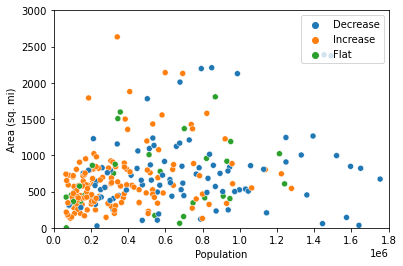

In [30]:
#County level EDA
pp = sns.scatterplot(data=df_all, x='Population', y='Area', hue='covid_drop')
pp.set(ylim=(0, 3000), xlim=(0,1.8e6), ylabel=('Area (sq. mi)'))
pp.legend(loc='upper right')

# Zip Code Level Models

In [39]:
# read in clean data set to try fits at Zip Code level
df = pd.read_csv('stationary_raw_data.csv')

In [40]:
df.head()

,ZipCode,County,State,ZORI,Year,Month,ZHVI,HPI,AQI,Population,Unemployment,Percent Bachelors,Permits,Total_Households,Med_Income,PCE,Rental Vacancy Rate,Job Openings,CommuteTime,Salwrkr,Govwrkr,GRAPI,Gini_Index,P_Density
0,10025,New York,NY,3020.0,2014,2,1056185.0,NaN,62.107143,1636268.0,7.1,31.2,1458.0,762228.0,76089.0,1.455676,4.5,212.0,31.3,84.1,8.3,734.7,0.5939,48582.779097
1,60657,Cook,IL,1583.0,2014,2,441010.0,158.76,59.571429,5246456.0,9.1,21.8,269.0,1938055.0,55069.0,1.455676,6.7,154.0,32.8,84.1,11.3,1440.3,0.4982,3209.057490
2,10023,New York,NY,3145.0,2014,2,1015651.0,NaN,62.107143,1636268.0,7.1,31.2,1458.0,762228.0,76089.0,1.455676,4.5,212.0,31.3,84.1,8.3,734.7,0.5939,48582.779097
3,77494,Fort Bend,TX,1746.0,2014,2,311407.0,154.29,NaN,685345.0,4.9,28.3,4368.0,214215.0,87973.0,1.455676,6.5,374.0,32.3,81.8,12.4,48.8,0.4318,773.431064
4,60614,Cook,IL,1752.0,2014,2,564138.0,146.37,59.571429,5246456.0,9.1,21.8,269.0,1938055.0,55069.0,1.455676,6.7,154.0,32.8,84.1,11.3,1440.3,0.4982,3209.057490


In [41]:
df['day']=15
df['date'] = pd.to_datetime(df[['Year','Month','day']])

In [42]:
#calculate gradient in ZORI per zip code assuming time step is always one month
allzc = df.ZipCode.unique()
ZORI_grads = []
for code in allzc:
    ZORI_grads.append(np.gradient(df[df['ZipCode']==code]['ZORI']))
z_grad = [item for sublist in ZORI_grads for item in sublist]
len(z_grad)

263463

In [44]:
# assemble corresponding dates
ZORI_dates = []
for code in allzc:
    ZORI_dates.append(df[df['ZipCode']==code]['date'])
z_date = [item for sublist in ZORI_dates for item in sublist]
len(z_date)

263463

In [45]:
# assemble corresponding Zip Codes
ZORI_codes = []
for code in allzc:
    ZORI_codes.append(df[df['ZipCode']==code]['ZipCode'])
z_code = [item for sublist in ZORI_codes for item in sublist]
len(z_code)

263463

In [84]:
slope_df = pd.DataFrame({'ZipCode':z_code,'Grad':z_grad, 'date':z_date})
df_grad = pd.merge(df, slope_df[['ZipCode','Grad','date']], on = ['ZipCode', 'date'], how = 'left')

In [159]:
df_clean.ZipCode.value_counts()

22041    284
20191    284
22030    284
22153    284
22102    284
        ... 
11753      7
83714      5
92210      5
92118      5
91320      5
Name: ZipCode, Length: 2637, dtype: int64

# Zip Code Level EDA

[Text(0, 0.5, 'ZORI for 20191'), Text(0.5, 0, 'Year'), (2013.5, 2019.5)]

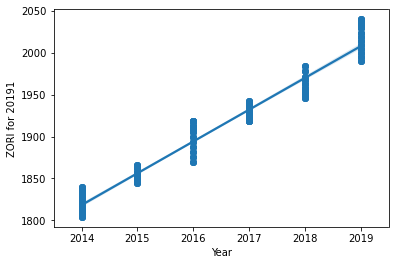

In [163]:
pp = sns.regplot(data=df_clean[(df_clean['ZipCode']==20191) & (df_clean['Year']<2020)], x='Year', y='ZORI')
#pp = sns.regplot(data=df_clean[(df_clean['ZipCode']==20191)], x='Year', y='ZORI')
pp.set(ylabel = ('ZORI for 20191'), xlabel=('Year'), xlim=(2013.5, 2019.5))

[Text(0, 0.5, 'Unemployment for 20191'),
 Text(0.5, 0, 'Year'),
 (2013.5, 2019.5)]

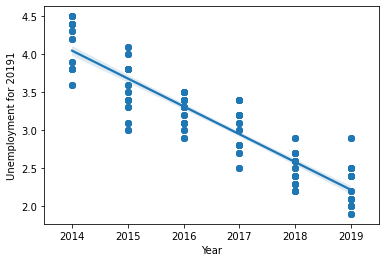

In [165]:
pp = sns.regplot(data=df_clean[(df_clean['ZipCode']==20191) & (df_clean['Year']<2020)], x='Year', y='Unemployment')
#pp = sns.regplot(data=df_clean[(df_clean['ZipCode']==20191)], x='Year', y='ZORI')
pp.set(ylabel = ('Unemployment for 20191'), xlabel=('Year'), xlim=(2013.5, 2019.5))

[Text(0, 0.5, 'ZORI for 10028'), Text(0.5, 0, 'Year')]

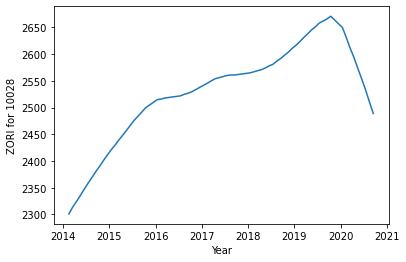

In [52]:
#county where rent decreased with COVID (in UES manhattan)
pp = sns.lineplot(data=df_grad[df_grad['ZipCode']==10028], x='date', y='ZORI', err_style=None)
pp.set(ylabel = ('ZORI for 10028'), xlabel=('Year'))
#pp.legend(loc='upper right')
#df_grad[df_grad['ZipCode']==10028].plot(y='ZORI', x='date')

[Text(0, 0.5, 'Gradient of ZORI for 10028'), Text(0.5, 0, 'Year')]

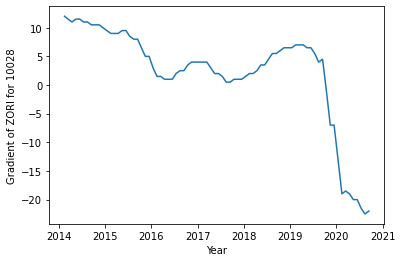

In [54]:
pp = sns.lineplot(data=df_grad[df_grad['ZipCode']==10028], x='date', y='Grad', err_style=None)
pp.set(ylabel = ('Gradient of ZORI for 10028'), xlabel=('Year'))

[Text(0, 0.5, 'ZORI for 10960'), Text(0.5, 0, 'Year')]

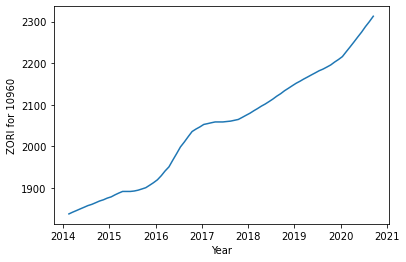

In [55]:
#county where ZORI increased with COVID (in Rockland County, NY)
pp = sns.lineplot(data=df_grad[df_grad['ZipCode']==10960], x='date', y='ZORI', err_style=None)
pp.set(ylabel = ('ZORI for 10960'), xlabel=('Year'))
#df_grad[df_grad['ZipCode']==10960].plot(y='ZORI', x='date')

[Text(0, 0.5, 'Gradient of ZORI for 10960'), Text(0.5, 0, 'Year')]

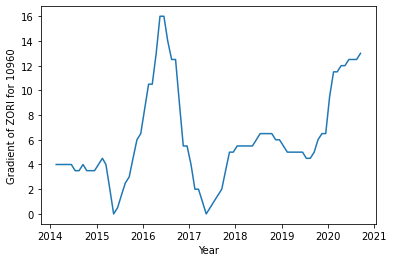

In [56]:
pp = sns.lineplot(data=df_grad[df_grad['ZipCode']==10960], x='date', y='Grad', err_style=None)
pp.set(ylabel = ('Gradient of ZORI for 10960'), xlabel=('Year'))

In [85]:
# create categorical variable for gradient of ZORI in 2020
df_grad_sub = df_grad[df_grad['Year']>2019].groupby('ZipCode')['Grad'].min().reset_index()
df_grad_sub['covid_drop']=df_grad_sub['Grad'].apply(lambda x: 1 if x>1 else -1)

In [86]:
df_grad_sub.covid_drop.value_counts()

 1    2162
-1    1102
Name: covid_drop, dtype: int64

In [87]:
df_grad = pd.merge(df_grad, df_grad_sub[['ZipCode','covid_drop']], on = ['ZipCode'], how = 'left')

In [88]:
df_grad.shape

(268149, 28)

In [89]:
df_grad.isnull().sum(axis=0)

ZipCode                    0
County                   160
State                     80
ZORI                   11963
Year                       0
Month                      0
ZHVI                   10560
HPI                    46558
AQI                    22560
Population             37338
Unemployment            7680
Percent Bachelors      37338
Permits                   80
Total_Households       37338
Med_Income             37338
PCE                        0
Rental Vacancy Rate    37648
Job Openings           11255
CommuteTime            37338
Salwrkr                37338
Govwrkr                37338
GRAPI                  37338
Gini_Index             37338
P_Density              37338
day                        0
date                       0
Grad                   20206
covid_drop                 0
dtype: int64

In [90]:
df_clean = df_grad[df_grad['Year']!=2020]
# Dropping all NaN values instead of imputing for simplicity for now
df_clean = df_clean[~df_clean['HPI'].isnull()]
df_clean = df_clean[~df_clean['AQI'].isnull()]
df_clean = df_clean[~df_clean['ZHVI'].isnull()]
df_clean = df_clean[~df_clean['Rental Vacancy Rate'].isnull()]
df_clean = df_clean[~df_clean['Grad'].isnull()]
df_clean = df_clean[~df_clean['ZORI'].isnull()]

In [91]:
df_clean.shape

(174562, 28)

In [92]:
df_clean.isnull().sum(axis=0)

ZipCode                0
County                 0
State                  0
ZORI                   0
Year                   0
Month                  0
ZHVI                   0
HPI                    0
AQI                    0
Population             0
Unemployment           0
Percent Bachelors      0
Permits                0
Total_Households       0
Med_Income             0
PCE                    0
Rental Vacancy Rate    0
Job Openings           0
CommuteTime            0
Salwrkr                0
Govwrkr                0
GRAPI                  0
Gini_Index             0
P_Density              0
day                    0
date                   0
Grad                   0
covid_drop             0
dtype: int64

In [93]:
df_clean.covid_drop.value_counts()

 1    118295
-1     56267
Name: covid_drop, dtype: int64

In [94]:
features = df_clean[['ZORI','ZHVI','HPI','AQI','Population','Unemployment','Percent Bachelors',
                     'Permits','Total_Households','Med_Income','PCE','Rental Vacancy Rate', 'Job Openings',
                    'CommuteTime', 'Salwrkr','Govwrkr','GRAPI','Gini_Index','P_Density']]
target = df_clean['covid_drop']

# Logistic Regression Model

In [95]:
from sklearn import linear_model

In [96]:
logit_1 = linear_model.LogisticRegression(solver='liblinear')

In [97]:
logit_1.fit(features, target)

LogisticRegression(solver='liblinear')

In [98]:
logit_1.score(features, target)

0.7041108603246984

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, logit_1.predict(features))

array([[ 11542,  44725],
       [  6926, 111369]])

In [100]:
from sklearn.metrics import classification_report
print(classification_report(target, logit_1.predict(features)))

              precision    recall  f1-score   support

          -1       0.62      0.21      0.31     56267
           1       0.71      0.94      0.81    118295

    accuracy                           0.70    174562
   macro avg       0.67      0.57      0.56    174562
weighted avg       0.68      0.70      0.65    174562



In [101]:
grid_para_logit=[{
    'C':[0.01,0.1,1.0,10.0],
    'penalty':['l2','l1','elasticnet']
}]

In [102]:
grid_search_logit = GridSearchCV(logit_1, grid_para_logit, cv = 5, n_jobs = -1)

In [103]:
grid_search_logit.fit(features, target)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10.0],
                          'penalty': ['l2', 'l1', 'elasticnet']}])

In [104]:
grid_search_logit.best_params_

{'C': 10.0, 'penalty': 'l1'}

In [105]:
grid_search_logit.best_score_

0.7229351797421917

In [107]:
y_pred = grid_search_logit.best_estimator_.predict(features)
confusion_matrix(target, y_pred)

array([[ 21644,  34623],
       [ 11439, 106856]])

In [109]:
grid_para_logit=[{
    'C':[10.0,20.0, 50.0],
    'penalty':['l1']
}]

In [110]:
grid_search_logit = GridSearchCV(logit_1, grid_para_logit, cv = 5, n_jobs = -1)

In [111]:
grid_search_logit.fit(features, target)

/Applications/anaconda3/envs/Base_new/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid=[{'C': [10.0, 20.0, 50.0], 'penalty': ['l1']}])

In [112]:
grid_search_logit.best_params_

{'C': 10.0, 'penalty': 'l1'}

In [135]:
# gives better results
logit_1.set_params(C=20, penalty='l1')
logit_1.fit(features, target)
logit_1.score(features, target)

0.7356583907150468

In [136]:
y_pred = logit_1.predict(features)
confusion_matrix(target, y_pred)

array([[ 21468,  34799],
       [ 11345, 106950]])

In [137]:
print(classification_report(target, logit_1.predict(features)))

              precision    recall  f1-score   support

          -1       0.65      0.38      0.48     56267
           1       0.75      0.90      0.82    118295

    accuracy                           0.74    174562
   macro avg       0.70      0.64      0.65    174562
weighted avg       0.72      0.74      0.71    174562



In [138]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

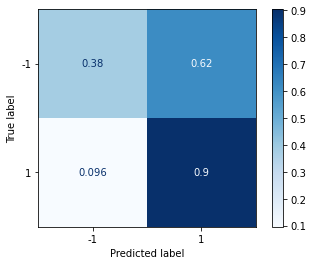

In [169]:
plot_confusion_matrix(logit_1, features, target, cmap=plt.cm.Blues, normalize='true')
plt.show()

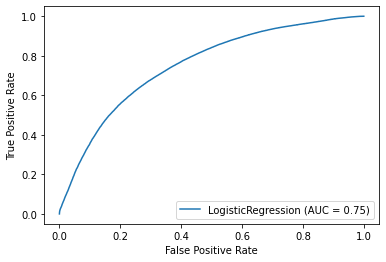

In [141]:
plot_roc_curve(logit_1, features, target)
plt.show()

# Random Forest Classifier

In [143]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
RF = RandomForestClassifier(max_depth=7, class_weight='balanced', n_jobs=-1) #n_estimators=1000
RF.fit(features, target)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_jobs=-1)

In [145]:
y_pred = RF.predict(features)

In [148]:
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.78      0.67     56267
           1       0.88      0.75      0.81    118295

    accuracy                           0.76    174562
   macro avg       0.73      0.76      0.74    174562
weighted avg       0.78      0.76      0.76    174562



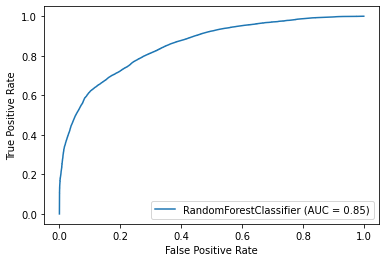

In [149]:
plot_roc_curve(RF, features, target)
plt.show()

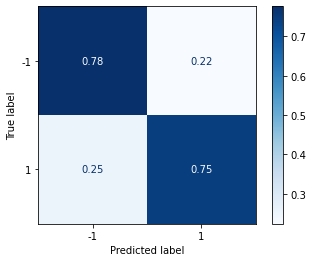

In [170]:
plot_confusion_matrix(RF, features, target, cmap=plt.cm.Blues, normalize='true')
plt.show()

In [171]:
RF.score(features, target)

0.7556856589635774

In [153]:
fi_values = pd.Series(RF.feature_importances_, index = features.columns).sort_values(ascending=False)
pd.DataFrame({'feature importance':fi_values})

,feature importance
ZHVI,0.206496
P_Density,0.152948
ZORI,0.125336
Percent Bachelors,0.089388
HPI,0.083244
CommuteTime,0.048999
Gini_Index,0.044432
Population,0.043543
Total_Households,0.042898
Med_Income,0.034992
